In [7]:
%matplotlib widget

In [10]:
from circuitree.viz import plot_network
from datetime import date, datetime
from functools import partial
import json
import matplotlib as mpl
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import networkx as nx
import numpy as np
from pathlib import Path
from seaborn.palettes import color_palette
from typing import Any, Callable, Iterable, Literal, Mapping, Optional

from graph_utils import (
    merge_search_graphs,
    _get_mean_reward,
    make_complexity_tree_mst,
    complexity_layout,
)


_edge_kwargs = dict(
    width=0.5,
    edge_color="black",
    alpha=1.0,
    edge_cmap=None,
)

_node_kwargs = dict(
    node_shape="o",
    node_size=2.0,
    # node_size=5,
    node_color="dimgray",
    edgecolors="dimgray",
    alpha=1.0,
    cmap=None,
)


_network_kwargs = dict(
    padding=0.5,
    lw=1,
    node_shrink=0.7,
    offset=0.8,
    auto_shrink=0.9,
    width=0.005,
    plot_labels=False,
)


def _color_by_log_Q_tilde(n: Any, tree: nx.DiGraph, cmap: str = "viridis", norm=None):
    log10_Q_tilde = np.log10(tree.nodes[n]["Q_tilde"])
    return to_rgba(plt.get_cmap(cmap)(norm(log10_Q_tilde)))


_node_ranks = dict()


def _color_by_rank(n: Any, tree: nx.DiGraph, cmap: Optional[str] = None):
    if not _node_ranks:
        terminal_nodes = []
        key = lambda n: _get_mean_reward(tree, n)
        terminal_nodes = sorted(
            (n for n in tree.nodes if tree.out_degree(n) == 0), key=key, reverse=True
        )
        for i, n in enumerate(terminal_nodes):
            _node_ranks[n] = i
    rank = _node_ranks[n]
    return to_rgba(color_palette(cmap, n_colors=len(_node_ranks))[rank])


def plot_complexity_tree(
    complexity_tree: nx.DiGraph,
    pos: Mapping[Any, tuple[float, float]] = None,
    min_depth: int = 0,
    edge_kwargs: Optional[Mapping[str, Any]] = None,
    node_kwargs: Optional[Mapping[str, Any]] = None,
    reverse_x: bool = False,
    fig: Optional[Figure] = None,
    ax: Optional[Axes] = None,
    fig_kwargs: Optional[Mapping[str, Any]] = None,
    plot_Q: bool = True,
    terminal_size: float = 1.0,
    color_func: Optional[Callable] = None,
    guide_position: Literal["left", "right"] = "right",
):
    if pos is None:
        pos = complexity_layout(complexity_tree)

    if reverse_x:
        pos = {k: (-x, y) for k, (x, y) in pos.items()}
    x_min = min(x for x, y in pos.values())
    x_max = max(x for x, y in pos.values())

    # Plotting options
    edge_kwargs = _edge_kwargs | (edge_kwargs or {})
    node_kwargs = _node_kwargs | (node_kwargs or {})

    # Create a figure and axis if none are provided
    if fig is None:
        fig_kwargs = fig_kwargs or {}
        fig, ax = plt.subplots(**fig_kwargs)
    elif ax is None:
        ax = fig.gca()

    if plot_Q:
        n_nodes = len(complexity_tree.nodes)
        kw = dict(
            node_size=[node_kwargs["node_size"]] * n_nodes,
            node_color=[node_kwargs["node_color"]] * n_nodes,
        )
        for i, n in enumerate(complexity_tree.nodes):
            # if complexity_tree.out_degree(n) > 0:
            #     continue
            kw["node_size"][i] = terminal_size
            if color_func is not None:
                kw["node_color"][i] = color_func(n, complexity_tree)

        node_kwargs = node_kwargs | kw

    nx.draw_networkx_edges(
        complexity_tree.to_undirected(as_view=True), pos=pos, ax=ax, **edge_kwargs
    )
    nx.draw_networkx_nodes(complexity_tree, pos=pos, ax=ax, **node_kwargs)

    # Plot node name labels
    nx.draw_networkx_labels(
        complexity_tree,
        pos=pos,
        ax=ax,
        labels={n: n.split("::")[-1] for n in complexity_tree.nodes},
        font_size=10,
    )
    
    plt.axis("off")

    # Plot a guide for the number of interactions in each level in the tree
    if guide_position == "right":
        x_depth = x_max + 0.05 * (x_max - x_min)
    elif guide_position == "left":
        x_depth = x_min - 0.05 * (x_max - x_min)
    else:
        raise ValueError(f"Invalid position for guide labels: {guide_position}")

    level_yvals = sorted(set(y for x, y in pos.values()))[::-1]
    dy = np.diff(-np.array(level_yvals)).min()
    plt.text(x_depth, level_yvals[0] + dy, "# actions", ha="center", va="top")
    for i, y in enumerate(level_yvals):
        plt.text(x_depth, y, i + min_depth, ha="center", va="center")

    # # Plot a colormap for the mean reward at each node
    # if colorbar:
    #     axins = inset_axes(
    #         ax,
    #         width="15%",
    #         height="5%",
    #         loc="upper right",
    #     )
    #     norm = plt.Normalize(vmin=0.0, vmax=vmax)
    #     cbar = plt.colorbar(
    #         ScalarMappable(norm, cmap=cmap),
    #         # ax=ax,
    #         cax=axins,
    #         shrink=0.2,
    #         orientation="horizontal",
    #         location="top",
    #         anchor=(0.8, 0.0),
    #         ticks=[0, round(vmax / 2, 1), 2 * round(vmax / 2, 1)],
    #     )
    #     cbar.ax.set_xlabel(r"$Q$")
    #     cbar.ax.tick_params(labelsize=8)

    return (fig, ax), pos


def main(
    search_graph_gml: Path | Iterable[Path],
    search_graph_json: Path,
    grammar: Any,
    success_cutoff: float = 0.01,
    n_best: int = 100,
    reverse_x: bool = False,
    plot_n_motifs: int = 5,
    edge_kwargs: Optional[Mapping[str, Any]] = None,
    node_kwargs: Optional[Mapping[str, Any]] = None,
    network_kwargs: Optional[Mapping[str, Any]] = None,
    plot_Q: bool = True,
    terminal_size: float = 25.0,
    color_func: Optional[Callable] = None,
    color_by_rank: bool = True,
    rank_cmap: str = "viridis_r",
    figsize: tuple = (10, 4),
    save_dir: Optional[Path] = None,
    save: bool = False,
    fmt: str = "png",
    dpi: int = 300,
    **kwargs,
):
    edge_kwargs = edge_kwargs or {}
    node_kwargs = node_kwargs or {}

    search_graph_json = Path(search_graph_json)
    with search_graph_json.open() as f:
        root_node = json.load(f)["root"]

    # Load the search graph, a DAG with a single root, from one or more GML files
    if isinstance(search_graph_gml, Path):
        G: nx.DiGraph = nx.read_gml(search_graph_gml)
    else:
        print(f"Merging {len(search_graph_gml)} search graphs...")
        search_graphs = [nx.read_gml(gml) for gml in search_graph_gml]
        G: nx.DiGraph = merge_search_graphs(search_graphs)
        print(f"Done. Merged graph has {len(G.nodes)} nodes.")

    # Check that the root node is valid
    if G.in_degree(root_node) != 0:
        raise ValueError("The specified root node is invalid.")

    # ##### for testing
    # # Use the LCB loss as a weight for the shortest paths
    # for e in G.edges:
    #     G.edges[e]["lcb_loss"] = lcb_loss(*e, G.edges[e], G)
    # weight_func = "lcb_loss"

    # Build the complexity tree, which is the union of the shortest paths from the root
    # to all states with mean reward above the cutoff

    # complexity_tree, tree_paths = make_complexity_tree_dijkstra(
    complexity_tree, tree_paths = make_complexity_tree_mst(
        G,
        root_node=root_node,
        grammar=grammar,
        success_cutoff=success_cutoff,
        n_best=n_best,
    )
    print(f"Complexity tree has {len(tree_paths)} terminal states.")

    # Color terminal nodes by their rank
    if color_by_rank:
        # color_func = partial(_color_by_rank, cmap=rank_cmap)
        Qs = np.array(list(nx.get_node_attributes(complexity_tree, "Q_tilde").values()))
        log10Qs = np.log10(Qs)
        norm = mpl.colors.Normalize(vmin=min(log10Qs), vmax=max(log10Qs))
        color_func = partial(_color_by_log_Q_tilde, cmap=rank_cmap, norm=norm)
    elif color_func is None:
        node_kwargs["node_color"] = "gray"
        color_func = lambda n, tree: "black"

    fig, ax = plt.subplots(figsize=figsize)
    _, pos = plot_complexity_tree(
        complexity_tree=complexity_tree,
        edge_kwargs=edge_kwargs,
        node_kwargs=node_kwargs,
        reverse_x=reverse_x,
        plot_Q=plot_Q,
        terminal_size=terminal_size,
        color_func=color_func,
        fig=fig,
        ax=ax,
        **kwargs,
    )


Complexity tree has 100 terminal states.


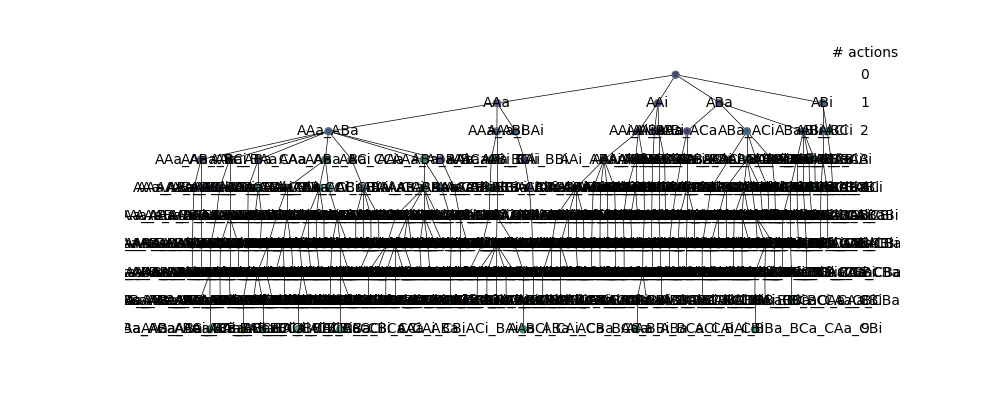

In [11]:
from oscillation import OscillationGrammar
# 5 million MCTS iterations - all 12 replicates
search_graph_gml = Path(
    "~/git/circuitree-paper/"
    "data/oscillation/mcts/bootstrap_long_230928_000832"
    "/231006_merged_tree_iter5000000.gml"
).expanduser()
graph_attrs_json = search_graph_gml.parent.joinpath(
    "0/oscillation_mcts_bootstrap_5000000_tree.json"
)
save_dir = Path("figures/oscillation")

grammar = OscillationGrammar(
    components=["A", "B", "C"], interactions=["activates", "inhibits"]
)

main(
    search_graph_gml=search_graph_gml,
    search_graph_json=graph_attrs_json,
    grammar=grammar,
    reverse_x=False,
    save_dir=save_dir,
    save=True,
    fmt="pdf",
    n_best=100,
    plot_n_motifs=0,
    rank_cmap="viridis",
)
